In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 2000
N_bar = 2000
num_states = 100
steps = 100
start_t = steps-25 # Start of time window

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    steps=steps,
)

In [4]:
cache_states = [25, 75]
forget_state = 75

# Run Task (with learning)

Now I just cached at location: 25
Now I just cached at location: 75
Recall after cache at sites 25 and 75:


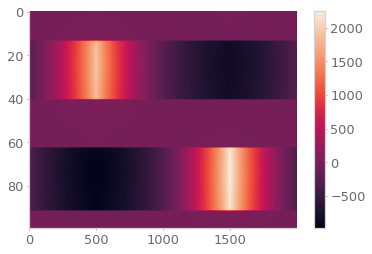

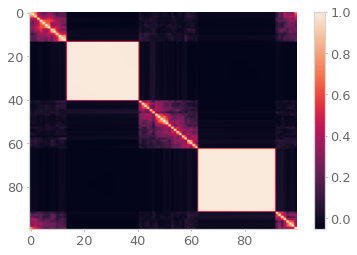

Recall after forgetting at site 75:


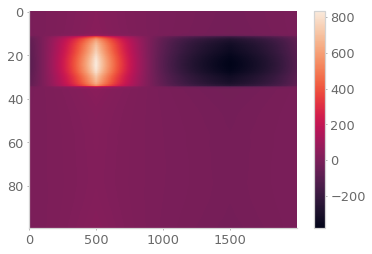

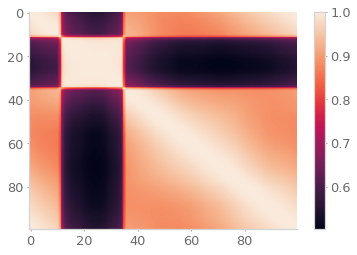

Recall after re-cache at site 75:


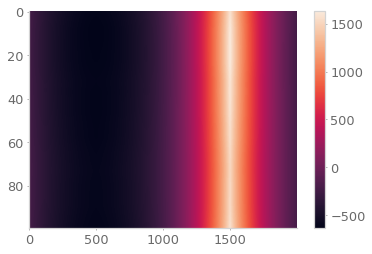

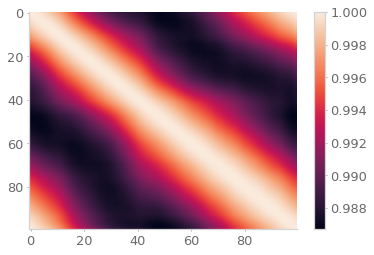

Recall after forgetting at site 75:


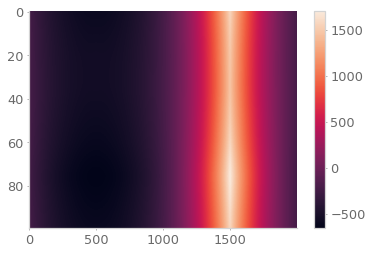

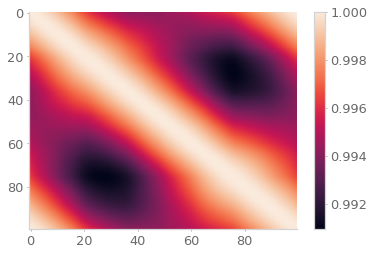

KeyboardInterrupt: 

In [9]:
def get_avg_cache_acts(cache_acts_over_time):
    avg_cache_acts = []
    for i in range(len(cache_acts_over_time)):
        location = cache_states[i]
        vec = cache_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
        avg_cache_acts.append(vec)
    avg_cache_acts = np.array(avg_cache_acts)
    return avg_cache_acts

def show_recall():
    _, recall_acts, recall_reconstruct, recall_acts_over_time = model.run_recall(
    1.0, place_inputs, n_zero_input=0)
    plt.figure()
    plt.imshow(recall_reconstruct, aspect='auto')
    plt.colorbar()
    plt.show()
    plt.imshow(np.corrcoef(recall_acts), aspect='auto')
    plt.colorbar()
    plt.show()
    
    
model.reset()
cache_acts = []
cache_acts_over_time = []
retrieval_acts = []
retrieval_acts_over_time = []
for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    if cache_state == forget_state:
        cache_acts.append(acts_over_time[steps-1][forget_state].copy())
        cache_acts_over_time.append(acts_over_time[forget_state].copy())
    

print("Recall after cache at sites 25 and 75:")
show_recall()




num_repeats = 20

for r in range(num_repeats):
    
    #'''
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    act_normalized = acts_over_time[steps-1][forget_state] / np.linalg.norm(acts_over_time[steps-1][forget_state])
    preact_normalized = preacts[forget_state] / np.linalg.norm(preacts[forget_state])
    model.J_xy -= np.dot(model.J_xy, act_normalized)[:, None] * act_normalized[None, :]
    change = model.J_xx - model.J_xx_orig
    change -= np.dot(model.J_xx, preact_normalized)[:, None] * preact_normalized[None, :]
    model.J_xx = model.J_xx_orig + change
    change -= np.dot(model.J_xx, act_normalized)[:, None] * act_normalized[None, :]
    model.J_xx = model.J_xx_orig + change
    
    
    #model.reverse_update(place_inputs[forget_state], acts[forget_state], preacts[forget_state], forget_lr_multiplier=0.5)
    retrieval_acts.append(acts_over_time[steps-1][forget_state].copy())
    retrieval_acts_over_time.append(acts_over_time[forget_state].copy())
    
    print("Recall after forgetting at site 75:")
    show_recall()
    #'''
    
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[forget_state], acts_over_time[steps-1][forget_state], preacts[forget_state])
    cache_acts.append(acts_over_time[steps-1][forget_state].copy())
    cache_acts_over_time.append(acts_over_time[forget_state].copy())
    print("Recall after re-cache at site 75:")
    
    show_recall()

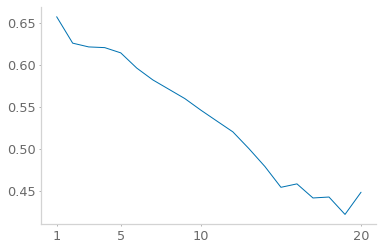

In [12]:
def cross_corr_from_pairwise(pairwise):
    results = []
    for i in range(1, len(pairwise)):
        results.append(np.diagonal(pairwise, offset=i).mean())
    return results

plt.plot(range(1, len(cache_acts)), cross_corr_from_pairwise(np.corrcoef(np.concatenate([cache_acts], axis=0))))
plt.xticks([1, 5, 10, 20])
plt.show()

In [12]:
for i in range(10):
    print(np.sum(cache_acts[i]))
    #print(np.sum(retrieval_acts[i]))

147.38154597479664
175.07303397109766
186.96431463638106
187.76905353750396
182.39079000853138
181.98650023902948
192.93720043431702


IndexError: list index out of range

In [13]:
for i in range(5):
    print(np.corrcoef(cache_acts[i], retrieval_acts[i])[0, 1])
    #print(np.corrcoef(cache_acts[i+1], retrieval_acts[i])[0, 1])
    print('**')

0.5954901120778505
**
0.9930996248203615
**
0.9964366646694146
**
0.9954877250839269
**
0.9952128709781635
**


In [24]:
model.J_xy.shape

(2000, 2000)

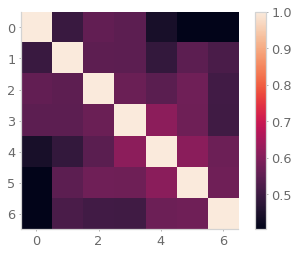

In [11]:
plt.imshow(np.corrcoef(np.concatenate([cache_acts], axis=0)))
plt.colorbar()
plt.show()